In [1]:
import $ivy.`org.apache.spark::spark-sql:2.4.3`


import org.apache.spark.sql._
import org.apache.spark.sql.functions._


//Reducir numero logs
import org.apache.log4j.{Level, Logger}
Logger.getLogger("org").setLevel(Level.OFF)


//Sttp para realizar request
import $ivy.`com.softwaremill.sttp.client::async-http-client-backend-monix:2.0.0-RC2`
import sttp.client.quick.{quickRequest, UriContext, backend}
import sttp.client.asynchttpclient.monix._
import sttp.client.basicRequest

//For adding extra dependenies
import $ivy.`org.typelevel::cats-core:1.6.0`

//Plotly
import $ivy.`org.plotly-scala::plotly-almond:0.7.1`
import plotly._, plotly.element._, plotly.layout._, plotly.Almond._

import $ivy.$                                  



import org.apache.spark.sql._

import org.apache.spark.sql.functions._


//Reducir numero logs

import org.apache.log4j.{Level, Logger}

import $ivy.$                                                                        

import sttp.client.quick.{quickRequest, UriContext, backend}

import sttp.client.asynchttpclient.monix._

import sttp.client.basicRequest

//For adding extra dependenies

import $ivy.$                               

//Plotly

import $ivy.$                                      

import plotly._, plotly.element._, plotly.layout._, plotly.Almond._

In [2]:
//Iniciamos session de Spark
val spark = {
  NotebookSparkSession.builder()
    .master("local[*]")
    .getOrCreate()
}
import spark.implicits._

//Crear URL
def createUri(category: String, widget: String, start_date: String, end_date: String, time_trunc: String, lang: String, 
              geo_trunc: String = "", geo_limit: String = "", geo_ids: String = ""): String = {
  val baseUrl = s"https://apidatos.ree.es/$lang/datos/$category/$widget"
  
// Crear un mapa con los parámetros obligatorios y opcionales
  val params = Map(
    "start_date" -> start_date,
    "end_date" -> end_date,
    "time_trunc" -> time_trunc,
    "geo_trunc" -> geo_trunc,
    "geo_limit" -> geo_limit,
    "geo_ids" -> geo_ids
  ).filter { case (_, v) => v.nonEmpty } // Filtrar los parámetros que no están vacíos

//Especifico el orden concreto de los paramtros ya que, Scala map no te garantiza el orden
  val orderedKeys = Seq("start_date", "end_date", "time_trunc", "geo_trunc", "geo_limit", "geo_ids")

// Unir los parámetros en una cadena
  val queryString = orderedKeys.flatMap(key => params.get(key).map(value => s"$key=$value")).mkString("&")
  
  s"$baseUrl?$queryString"
}

//Lanzar llamada y obtener guardar datos
def getDataApi(apiUrl: String): Either[String, String] = {
 
    val newRequest = basicRequest.get(uri"$apiUrl")
    val response = newRequest.send()
  
  response.body match {
    case Right(body) => 
      Right(body)
      
    case Left(error) => 
      Left(s"Error fetching data: $error")
  }
}

// Transformar response a DataFrame
def responseToDF(response: Either[String, String]): DataFrame = {
    response match {
    case Right(body) => 
        val rdd = spark.sparkContext.parallelize(Seq(body))
        spark.read.json(rdd)
    case Left(error) => 
        println(error)
        spark.emptyDataFrame
    }
}



Loading spark-stubs
Getting spark JARs
Creating SparkSession


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties


Spark UI

spark: SparkSession = org.apache.spark.sql.SparkSession@38b6593a
import spark.implicits._

//Crear URL

defined function createUri
defined function getDataApi
defined function responseToDF

In [3]:
val filePath = "data/ModelosCsv/datosDemanda14-24.csv"
val dfDemandaTiempoReal : DataFrame = spark.read
  .option("header", "true") // Si el archivo tiene un encabezado
  .option("inferSchema", "true") // Para inferir automáticamente el esquema
  .csv(filePath)

dfDemandaTiempoReal.show()

csv at cmd2.sc:5

1 / 1

csv at cmd2.sc:5

8 / 8

show at cmd2.sc:7

1 / 1

+-------------------+--------------+-------------------+----------------+---------------------+----------+-------------------+
|              Fecha|Valor_previsto|Porcentaje_previsto|Valor_programado|Porcentaje_programado|Valor_real|    Porcentaje_real|
+-------------------+--------------+-------------------+----------------+---------------------+----------+-------------------+
|2013-12-31 23:00:00|         24482|0.33478742461744637|           24099|    0.329549961026707|     24546|0.33566261435584666|
|2013-12-31 23:10:00|         24147|0.33280959272276206|           24099|   0.3321480256357246|     24309|0.33504238164151334|
|2013-12-31 23:20:00|         23882|0.33018567932641124|           24099|  0.33318585906068104|     24348|0.33662846161290766|
|2013-12-31 23:30:00|         23688|0.32850723914128804|           24099|   0.3342070227991346|     24321| 0.3372857380595773|
|2013-12-31 23:40:00|         23563|0.32791972834558003|           24099|   0.3353790915163661|     24194| 0.33

filePath: String = "data/ModelosCsv/datosDemanda14-24.csv"
dfDemandaTiempoReal: DataFrame = [Fecha: timestamp, Valor_previsto: int ... 5 more fields]

collect at cmd3.sc:12

8 / 8

collect at cmd3.sc:12

200 / 200

collect at cmd3.sc:12

200 / 200

collect at cmd3.sc:12

11 / 11

collect at cmd3.sc:13

8 / 8

collect at cmd3.sc:13

200 / 200

collect at cmd3.sc:13

200 / 200

collect at cmd3.sc:13

11 / 11

collect at cmd3.sc:14

8 / 8

collect at cmd3.sc:14

200 / 200

collect at cmd3.sc:14

200 / 200

collect at cmd3.sc:14

11 / 11

collect at cmd3.sc:15

8 / 8

collect at cmd3.sc:15

200 / 200

collect at cmd3.sc:15

200 / 200

collect at cmd3.sc:15

11 / 11

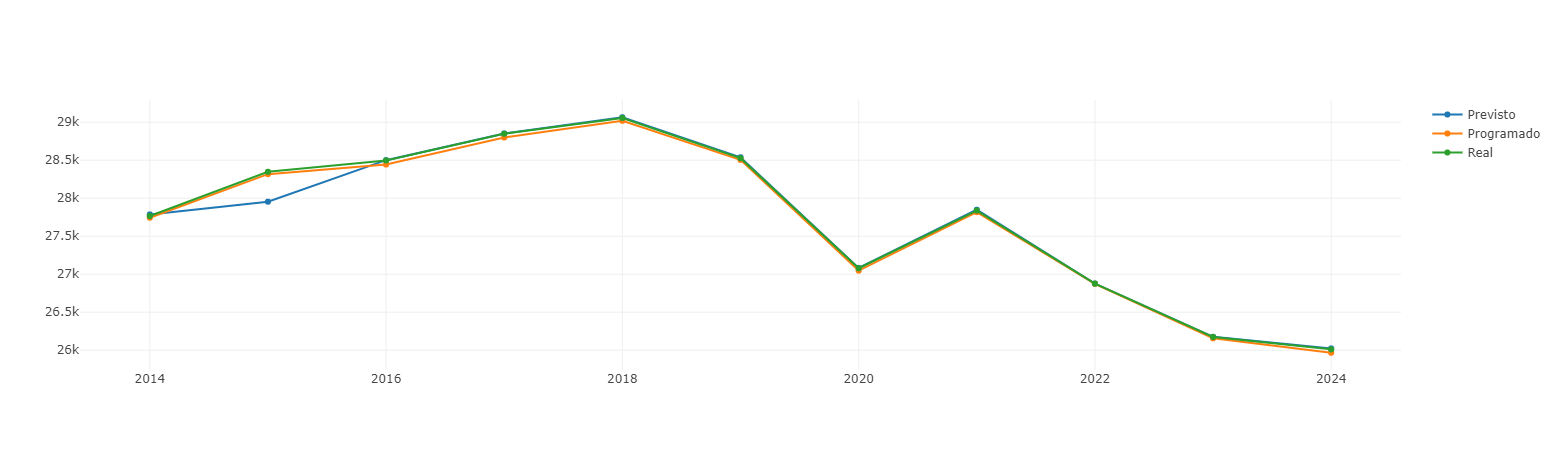

defined function demandaHistoricoAnual

In [4]:
def demandaHistoricoAnual(): Unit = {
  val dfPromedioAnual = dfDemandaTiempoReal
    .filter(year(col("Fecha")) =!= 2013)
    .groupBy(date_format(col("Fecha"), "yyyy").as("Año"))
    .agg(
      avg("Valor_previsto").as("Valor_previsto_avg_año"),
      avg("Valor_programado").as("Valor_programado_avg_año"),
      avg("Valor_real").as("Valor_real_avg_año")
    )
    .orderBy(col("Año"))

  val seqValorPrevisto = dfPromedioAnual.select("Valor_previsto_avg_año").as[Double].collect.toSeq
  val seqValorProgramado = dfPromedioAnual.select("Valor_programado_avg_año").as[Double].collect.toSeq
  val seqValorReal = dfPromedioAnual.select("Valor_real_avg_año").as[Double].collect.toSeq
  val seqAños = dfPromedioAnual.select("Año").as[String].collect.toSeq

  val tracePrevisto = Scatter(seqAños, seqValorPrevisto, name = "Previsto")
  val traceProgramado = Scatter(seqAños, seqValorProgramado, name = "Programado")
  val traceReal = Scatter(seqAños, seqValorReal, name = "Real")
     
  val data = Seq(tracePrevisto, traceProgramado, traceReal)
  plot(data)
}

demandaHistoricoAnual()

In [5]:
def demandaHistoricoMensual(df: DataFrame, año: Int): Unit = {
  val dfPromedioMensual = df
    .filter(year(col("Fecha")) === año)
    .groupBy(date_format(col("Fecha"), "yyyy-MM").as("Mes"))
    .agg(
      avg("Valor_previsto").as("Valor_previsto_avg_mes"),
      avg("Valor_programado").as("Valor_programado_avg_mes"),
      avg("Valor_real").as("Valor_real_avg_mes")
    )
    .orderBy(col("Mes"))

  val seqValorPrevisto = dfPromedioMensual.select("Valor_previsto_avg_mes").as[Double].collect.toSeq
  val seqValorProgramado = dfPromedioMensual.select("Valor_programado_avg_mes").as[Double].collect.toSeq
  val seqValorReal = dfPromedioMensual.select("Valor_real_avg_mes").as[Double].collect.toSeq
  val seqMeses = dfPromedioMensual.select("Mes").as[String].collect.toSeq

  val tracePrevisto = Scatter(seqMeses, seqValorPrevisto, name = "Previsto")
  val traceProgramado = Scatter(seqMeses, seqValorProgramado, name = "Programado")
  val traceReal = Scatter(seqMeses, seqValorReal, name = "Real")
     
  val data = Seq(tracePrevisto, traceProgramado, traceReal)
  plot(data)
}

defined function demandaHistoricoMensual

In [6]:
def demandaHistoricoDiario(df: DataFrame, año: Int, mes: Int): Unit = {
  val dfFiltrado = df.filter(year(col("Fecha")) === año && month(col("Fecha")) === mes)
  
  val dfPromedioDiario = dfFiltrado
    .groupBy(date_format(col("Fecha"), "yyyy-MM-dd").as("Día"))
    .agg(
      avg("Valor_previsto").as("Valor_previsto_avg_día"),
      avg("Valor_programado").as("Valor_programado_avg_día"),
      avg("Valor_real").as("Valor_real_avg_día")
    )
    .orderBy(col("Día"))

  val seqValorPrevisto = dfPromedioDiario.select("Valor_previsto_avg_día").as[Double].collect.toSeq
  val seqValorProgramado = dfPromedioDiario.select("Valor_programado_avg_día").as[Double].collect.toSeq
  val seqValorReal = dfPromedioDiario.select("Valor_real_avg_día").as[Double].collect.toSeq
  val seqDías = dfPromedioDiario.select("Día").as[String].collect.toSeq

  val tracePrevisto = Scatter(seqDías, seqValorPrevisto, name = "Previsto")
  val traceProgramado = Scatter(seqDías, seqValorProgramado, name = "Programado")
  val traceReal = Scatter(seqDías, seqValorReal, name = "Real")
     
  val data = Seq(tracePrevisto, traceProgramado, traceReal)
  plot(data)
}

// Ejemplo de uso para el mes de enero de 2015
//demandaHistoricoDiario(dfDemandaTiempoReal, 2015, 4)


defined function demandaHistoricoDiario

collect at cmd7.sc:15

8 / 8

collect at cmd7.sc:15

200 / 200

collect at cmd7.sc:15

200 / 200

collect at cmd7.sc:15

24 / 24

collect at cmd7.sc:16

8 / 8

collect at cmd7.sc:16

200 / 200

collect at cmd7.sc:16

200 / 200

collect at cmd7.sc:16

24 / 24

collect at cmd7.sc:17

8 / 8

collect at cmd7.sc:17

200 / 200

collect at cmd7.sc:17

200 / 200

collect at cmd7.sc:17

24 / 24

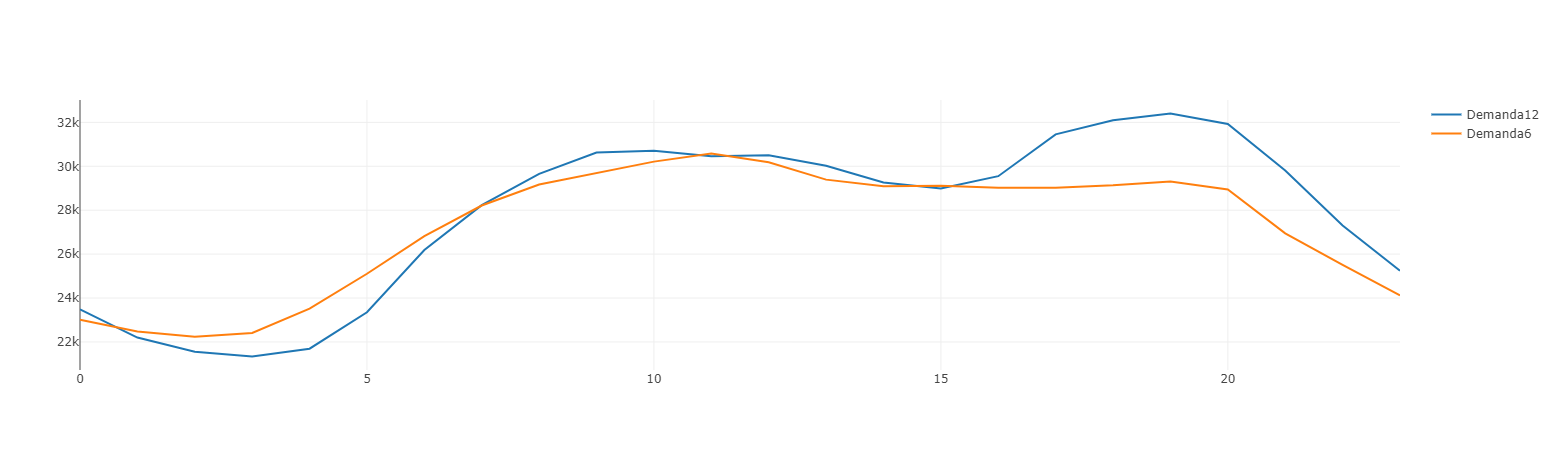

defined function demandaHistoricoPromedioPorHora

In [8]:
def demandaHistoricoPromedioPorHora(dfDemanda: DataFrame, mes1: Int, mes2: Int): Unit = {
    val df1 = dfDemanda
        .filter(month($"Fecha") === mes1)
        .select("Valor_real", "Fecha")
        .groupBy(date_format(col("Fecha"), "HH").as("Hora"))
        .agg(avg("Valor_real").as("PromedioPorHora"))
        .orderBy(col("Hora"))
     val df2 = dfDemanda
        .filter(month($"Fecha") === mes2)
        .select("Valor_real", "Fecha")
        .groupBy(date_format(col("Fecha"), "HH").as("Hora"))
        .agg(avg("Valor_real").as("PromedioPorHora"))
        .orderBy(col("Hora"))

    val seqDemanda1 = df1.select("PromedioPorHora").as[Double].collect.toSeq
    val seqDemanda2 = df2.select("PromedioPorHora").as[Double].collect.toSeq
    val seqHoras = df1.select("Hora").as[String].collect.toSeq

    val trace1 = Scatter(seqHoras, seqDemanda1, name = "Demanda" + mes1)
    val trace2 = Scatter(seqHoras, seqDemanda2, name = "Demanda" + mes2)

    val data = Seq(trace1, trace2)
    plot(data)
}

// Ejemplo de uso
demandaHistoricoPromedioPorHora(dfDemandaTiempoReal, 12, 6)

In [18]:
val filePath = "data/ModelosCsv/datasetMercados14-24.csv"
val dataFrameMercados: DataFrame = spark.read
  .option("header", "true") // Si el archivo tiene un encabezado
  .option("inferSchema", "true") // Para inferir automáticamente el esquema
  .csv(filePath)

val dfMercados = dataFrameMercados.orderBy("Fecha")

csv at cmd17.sc:5

200 / 200

csv at cmd17.sc:5

1 / 1

csv at cmd17.sc:5

8 / 8

filePath: String = "data/ModelosCsv/datasetMercados14-24.csv"
dataFrameMercados: DataFrame = [Fecha: timestamp, Valor_PVPC: double ... 3 more fields]
dfMercados: Dataset[Row] = [Fecha: timestamp, Valor_PVPC: double ... 3 more fields]

In [17]:
def diaConMasDemanda(dfDemanda: DataFrame): Unit = {
    val dfPicoDemanda = dfDemanda
        .groupBy(date_format(col("Fecha"), "yyyy-MM-dd").as("dia"))
        .agg(
            avg("Valor_real").as("DemandaMediaPorDia"),
        )
        .orderBy(col("DemandaMediaPorDia").desc)
    val dia = dfPicoDemanda.select("dia").as[String].first()
    println(s"El día con mayor demanda es: $dia")
}

// Ejemplo de uso
diaConMasDemanda(dfDemandaTiempoReal)


first at cmd16.sc:8

8 / 8

first at cmd16.sc:8

200 / 200

El día con mayor demanda es: 2017-01-19


defined function diaConMasDemanda

In [16]:
dfDemandaTiempoReal.orderBy($"Valor_real".desc).select("Fecha", "Valor_real").first()

first at cmd15.sc:1

8 / 8

res15: Row = [2021-01-08 12:20:00.0,42052]

In [ ]:
dfDemandaTiempoReal
    .groupBy(date_format(col("Fecha"), "yyyy-MM").as("Mes"))
        .agg(
            avg("Valor_real").as("DemandaMediaPorDia"),
        )
    .orderBy($"Valor_real".desc)
    .select("Mes", "Valor_real").first()